# Lab3. Build your CNN script with Tensorflow

In this lab, you will develop your own Tensorflow-based Keras CNN script to recognize charactors from cropped license plate.  

* Make sure the Tensorflow eager mode was enabled by code:  
 tf.enable_eager_execution()

In [1]:
import numpy as np
from keras import layers


# from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
# from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
# from keras.models import Model
# from keras.preprocessing import image
# from keras.utils import layer_utils
# from keras.utils.data_utils import get_file
# from keras.applications.imagenet_utils import preprocess_input
# # import pydot
# # from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot
# from keras.utils import plot_model
# # from kt_utils import *
# from keras.layers import concatenate


import os
import argparse

import json
from PIL import Image
# from PIL import ImageDraw
# from PIL import ImageFont

# import keras.backend as K
# K.set_image_data_format('channels_last')
# import matplotlib.pyplot as plt
# from matplotlib.pyplot import imshow
import tensorflow as tf

from tensorflow.contrib.eager.python import tfe

tf.enable_eager_execution()

Using TensorFlow backend.


In [25]:
NUMS =['1', '2', '3', '4', '5', '6', '7', '8', '9', '0']
CHARS=['가', '나', '다', '라', '마', '거', '너', '더', '러', '머', '고', '노', '도', '로', '모', '구', '누', '두', '루', '무', 
       '버', '서', '어', '저', '처', '커', '터', '퍼', '보', '소', '오', '조', '초', '코', '토', '포', '부', '수', '우', '주', '추', '쿠', '투', '푸', '후', 
       '그', '느', '드', '르', '므', '브', '스', '으', '즈', '츠', '크', '트', '프', '흐',
       '바', '사', '아', '자', '차', '카', '타', '파', '하', '허', '호']
SPACE=[' ']
JOIN =NUMS + CHARS + SPACE
n_chr = len(JOIN)

## Divide train and valdiation data from cropped images

In [3]:
jsons = os.listdir('gen/nums-tags')
print ('There are {:,} images have annotation files.'.format(len(jsons)))
print ('There are {:,} image files.'.format(len(os.listdir('gen/cropped-imgs'))))

There are 5,000 images have annotation files.
There are 5,000 image files.


* prepare folder to store divided train/validation data

In [4]:
!rm -fR tf
!mkdir tf tf/tf-train tf/tf-train_annotation tf/tf-validation tf/tf-validation_annotation

* Define the number of train/valdiation images

In [5]:
n_samples = len(os.listdir('gen/cropped-imgs'))
n_val = 5000 if n_samples > 25000 else round(n_samples * 0.2)
n_train = n_samples - n_val
print('{:,} images will be used for training, and {:,} images will be used for validation.'.format(n_train, n_val))

4,000 images will be used for training, and 1,000 images will be used for validation.


* Move images and annotation files to tf-train and tf-validation folders  

In [6]:
import shutil

train_jsons = jsons[:n_train]
val_jsons = jsons[n_train:]

#Moving training files to the training folders
for i in train_jsons:
    image_file = './gen/cropped-imgs/'+i.split('.')[0]+'.png'
    shutil.move(image_file, './tf/tf-train/')
    shutil.move('./gen/nums-tags/'+i, './tf/tf-train_annotation/')

#Moving validation files to the validation folders
for i in val_jsons:
    image_file = './gen/cropped-imgs/'+i.split('.')[0]+'.png'
    shutil.move(image_file, './tf/tf-validation/')
    shutil.move('./gen/nums-tags/'+i, './tf/tf-validation_annotation/')

* check the move result

In [7]:
print('there are {:,} files in gen/cropped-imgs folder.'.format(len(os.listdir('gen/cropped-imgs'))))
print('there are {:,} files in gen/nums-tags folder.'.format(len(os.listdir('gen/nums-tags'))))
print('there are {:,} files in tf/tf-train folder.'.format(len(os.listdir('tf/tf-train'))))
print('there are {:,} files in tf/tf-train_annotation folder.'.format(len(os.listdir('tf/tf-train_annotation'))))
print('there are {:,} files in tf/tf-validation folder.'.format(len(os.listdir('tf/tf-validation'))))
print('there are {:,} files in tf/tf-validation_annotation folder.'.format(len(os.listdir('tf/tf-validation_annotation'))))

there are 0 files in gen/cropped-imgs folder.
there are 0 files in gen/nums-tags folder.
there are 4,000 files in tf/tf-train folder.
there are 4,000 files in tf/tf-train_annotation folder.
there are 1,000 files in tf/tf-validation folder.
there are 1,000 files in tf/tf-validation_annotation folder.


## Load data(images/annotations) for local training

* Define a function to read the pair of cropped image and annotation
* Image will be resized to 128 x 64
* annotation will have list of 7 digits

In [43]:
def get_data_pair(train_dir, annotation_dir):
    t_jsns = os.listdir(annotation_dir)
    flg_first = True
    for i in t_jsns:
        ext = i.split('.')[1]
        if ext == 'json':
            with open(annotation_dir + i, "r") as jfile:
                jdata = json.load(jfile)
                # read image
                img=Image.open(train_dir + jdata['file']) 
                img = img.resize((128, 64))
                imgs = img if flg_first else np.append(imgs, img)
                # read license plate numbers
                n_ = np.array(jdata['nums'])
                Y_t = np.zeros((n_chr, 7))
                Y_t[n_, np.arange(7)] = 1
                Y_ = Y_t if (flg_first) else np.append(Y_, Y_t)
                flg_first = False
    Y_= np.split(Y_.reshape([-1,7]), 7, axis=1)
    return imgs.reshape([-1, 128, 64, 1])/255., [i.reshape([-1,81]) for i in Y_]

In [46]:
t_imgs, t_annotations = get_data_pair('tf/tf-train/', 'tf/tf-train_annotation/')
v_imgs, v_annotations = get_data_pair('tf/tf-validation/', 'tf/tf-validation_annotation/')

* Check 10 sample pairs

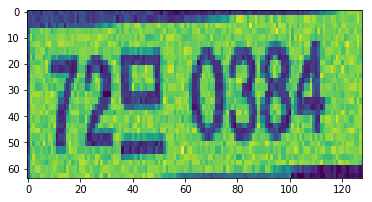

['7', '2', '므', '0', '3', '8', '4']


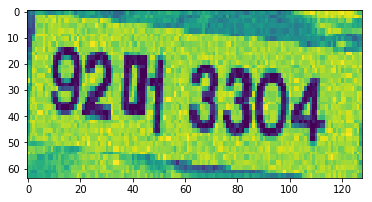

['9', '2', '머', '3', '3', '0', '4']


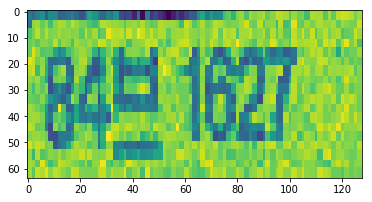

['8', '4', '브', '1', '6', '2', '7']


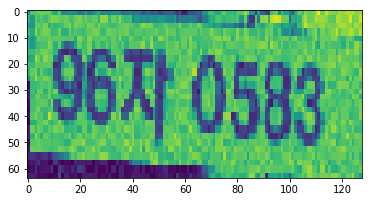

['9', '6', '자', '0', '5', '8', '3']


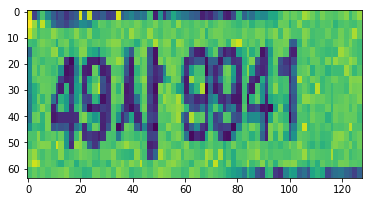

['4', '9', '사', '9', '9', '4', '1']


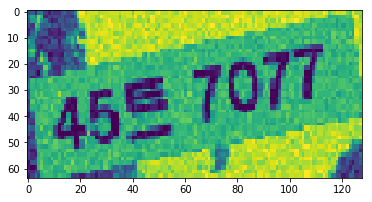

['4', '5', '트', '7', '0', '7', '7']


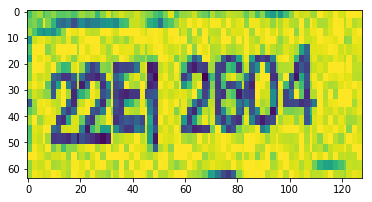

['2', '2', '터', '2', '6', '0', '4']


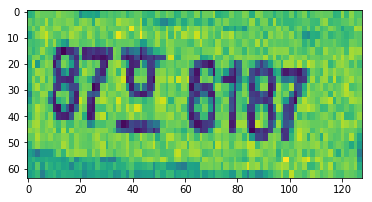

['8', '7', '흐', '6', '1', '8', '7']


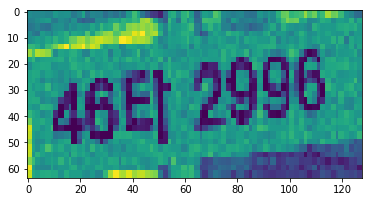

['4', '6', '타', '2', '9', '9', '6']


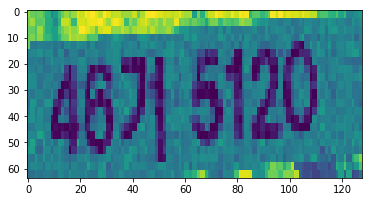

['4', '6', '거', '5', '1', '2', '0']


In [63]:
for i in range(10):
    plt.imshow(t_imgs[i].reshape([64,128]))
    plt.show()
    digits = [JOIN[np.argmax(t_annotations[0][i])], 
              JOIN[np.argmax(t_annotations[1][i])], 
              JOIN[np.argmax(t_annotations[2][i])], 
              JOIN[np.argmax(t_annotations[3][i])], 
              JOIN[np.argmax(t_annotations[4][i])], 
              JOIN[np.argmax(t_annotations[5][i])], 
              JOIN[np.argmax(t_annotations[6][i])]]
    print(digits)

In [66]:
print('{:,} train images and {:,} annotations were loaded.'.format(len(t_imgs),len(t_annotations[0])))
print('{:,} validation images and {:,} annotations were loaded.'.format(len(v_imgs),len(v_annotations[0])))

4,000 train images and 4,000 annotations were loaded.
1,000 validation images and 1,000 annotations were loaded.


* Define CNN model

In [96]:
def model(input_shape):
    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = tf.keras.Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    X = tf.keras.layers.ZeroPadding2D((2, 2))(X_input)

    # CONV0 -> BN -> RELU -> MAXPOOL applied to X
    X = tf.keras.layers.Conv2D(48, (5, 5), strides = (1, 1), name = 'conv0')(X)
    X = tf.keras.layers.BatchNormalization(axis = 3, name = 'bn0')(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D((2, 2), strides = (2, 2), name='max_pool0')(X)

    # CONV1 -> BN -> RELU -> MAXPOOL applied to X
    X = tf.keras.layers.Conv2D(64, (5, 5), strides = (1, 1), name = 'conv1')(X)
    X = tf.keras.layers.BatchNormalization(axis = 3, name = 'bn1')(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D((1, 2), strides = (2, 2), name='max_pool1')(X)

    # CONV2 -> BN -> RELU -> MAXPOOL applied to X
    X = tf.keras.layers.Conv2D(64, (5, 5), strides = (1, 1), name = 'conv2')(X)
    X = tf.keras.layers.BatchNormalization(axis = 3, name = 'bn2')(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D((2, 2), strides = (2, 2), name='max_pool2')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = tf.keras.layers.Flatten()(X)
#     X = tf.keras.layers.Dense(7, activation='softmax', name='fc')(X)

    #----------------------------------------------------------
    d1 = tf.keras.layers.Dense(81, activation='softmax', name='d1')(X)
    d2 = tf.keras.layers.Dense(81, activation='softmax', name='d2')(X)
    d3 = tf.keras.layers.Dense(81, activation='softmax', name='d3')(X)
    d4 = tf.keras.layers.Dense(81, activation='softmax', name='d4')(X)
    d5 = tf.keras.layers.Dense(81, activation='softmax', name='d5')(X)
    d6 = tf.keras.layers.Dense(81, activation='softmax', name='d6')(X)
    d7 = tf.keras.layers.Dense(81, activation='softmax', name='d7')(X)
    
    model = tf.keras.Model(inputs = X_input, 
                  outputs = [d1,d2,d3,d4,d5,d6,d7],
                  name='CNN_ANPR')

    return model

In [97]:
input_shape = (128,64,1)
model_k = model(input_shape)
model_k.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
                loss=['categorical_crossentropy','categorical_crossentropy','categorical_crossentropy','categorical_crossentropy',
                      'categorical_crossentropy','categorical_crossentropy','categorical_crossentropy'],
                metrics = ["accuracy"])
model_k.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 128, 64, 1)   0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 132, 68, 1)   0           input_4[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 64, 48)  1248        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
bn0 (BatchNormalization)        (None, 128, 64, 48)  192         conv0[0][0]                      
__________________________________________________________________________________________________
activation

In [ ]:
%%time
model_k.fit(t_imgs, [i.reshape([-1,81]) for i in t_annotations], 
            validation_data=(v_imgs, [i.reshape([-1,81]) for i in v_annotations]), 
            epochs=10, batch_size=128, verbose=1)

Epoch 1/10
32/32 [==============================] - 158s 5s/step - loss: 2.8894 - d1_loss: 0.3964 - d2_loss: 0.3889 - d3_loss: 0.3099 - d4_loss: 0.3114 - d5_loss: 0.3240 - d6_loss: 0.5625 - d7_loss: 0.5963 - d1_acc: 0.9028 - d2_acc: 0.8979 - d3_acc: 0.9580 - d4_acc: 0.9387 - d5_acc: 0.9216 - d6_acc: 0.8403 - d7_acc: 0.8450 - val_loss: 15.7448 - val_d1_loss: 1.7878 - val_d2_loss: 1.9034 - val_d3_loss: 3.7805 - val_d4_loss: 1.7993 - val_d5_loss: 1.7589 - val_d6_loss: 2.0272 - val_d7_loss: 2.6877 - val_d1_acc: 0.3520 - val_d2_acc: 0.3470 - val_d3_acc: 0.0570 - val_d4_acc: 0.3960 - val_d5_acc: 0.3930 - val_d6_acc: 0.2660 - val_d7_acc: 0.1420
Epoch 2/10
32/32 [==============================] - 158s 5s/step - loss: 2.1328 - d1_loss: 0.2894 - d2_loss: 0.3008 - d3_loss: 0.1945 - d4_loss: 0.2209 - d5_loss: 0.2536 - d6_loss: 0.4172 - d7_loss: 0.4564 - d1_acc: 0.9480 - d2_acc: 0.9316 - d3_acc: 0.9829 - d4_acc: 0.9724 - d5_acc: 0.9407 - d6_acc: 0.9021 - d7_acc: 0.9004 - val_loss: 15.2366 - val_d1_

In [71]:
input_shape = (128,64,1)
model_k = model(input_shape)
model_k.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
                loss=['categorical_crossentropy','categorical_crossentropy','categorical_crossentropy','categorical_crossentropy',
                      'categorical_crossentropy','categorical_crossentropy','categorical_crossentropy'],
                metrics = ["accuracy"])
model_k.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 64, 1)   0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 132, 68, 1)   0           input_3[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 64, 48)  1248        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
bn0 (BatchNormalization)        (None, 128, 64, 48)  192         conv0[0][0]                      
__________________________________________________________________________________________________
activation

In [102]:
%%time

model_k.fit(t_imgs, [i.reshape([-1,81]) for i in t_annotations], 
            validation_data=(v_imgs, [i.reshape([-1,81]) for i in v_annotations]), 
            epochs=10, batch_size=64, verbose=1)

Epoch 1/10
63/63 [==============================] - 158s 3s/step - loss: 0.2710 - d1_loss: 0.0385 - d2_loss: 0.0407 - d3_loss: 0.0231 - d4_loss: 0.0298 - d5_loss: 0.0278 - d6_loss: 0.0537 - d7_loss: 0.0574 - d1_acc: 0.9998 - d2_acc: 0.9998 - d3_acc: 1.0000 - d4_acc: 1.0000 - d5_acc: 1.0000 - d6_acc: 0.9995 - d7_acc: 1.0000 - val_loss: 8.2037 - val_d1_loss: 0.8299 - val_d2_loss: 1.0552 - val_d3_loss: 2.1873 - val_d4_loss: 0.5831 - val_d5_loss: 0.9670 - val_d6_loss: 1.2120 - val_d7_loss: 1.3691 - val_d1_acc: 0.7100 - val_d2_acc: 0.6740 - val_d3_acc: 0.3980 - val_d4_acc: 0.8130 - val_d5_acc: 0.6920 - val_d6_acc: 0.6170 - val_d7_acc: 0.5860
Epoch 2/10
63/63 [==============================] - 157s 2s/step - loss: 0.3116 - d1_loss: 0.0421 - d2_loss: 0.0509 - d3_loss: 0.0247 - d4_loss: 0.0308 - d5_loss: 0.0342 - d6_loss: 0.0627 - d7_loss: 0.0662 - d1_acc: 0.9988 - d2_acc: 0.9985 - d3_acc: 1.0000 - d4_acc: 0.9998 - d5_acc: 1.0000 - d6_acc: 0.9985 - d7_acc: 0.9970 - val_loss: 8.0036 - val_d1_lo

In [103]:
### START CODE HERE ### (1 line)
preds = model_k.evaluate(v_imgs, [i.reshape([-1,81]) for i in v_annotations], batch_size=32, verbose=1, sample_weight=None)
### END CODE HERE ###
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

32/32 [==============================] - 7s 207ms/step

Loss = 7.178739852905274
Test Accuracy = 0.7370188719034195


In [104]:
prediction = model_k.predict(v_imgs[:10])

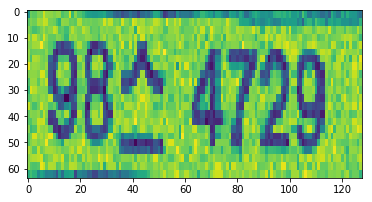

['9', '6', '스', '4', '7', '2', '2']


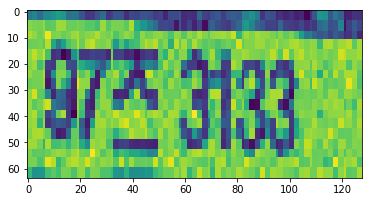

['0', '7', '즈', '3', '8', '7', '3']


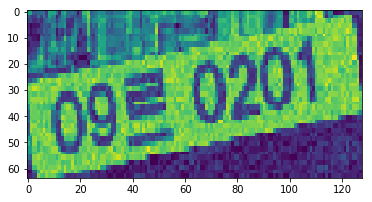

['0', '0', '로', '0', '2', '9', '0']


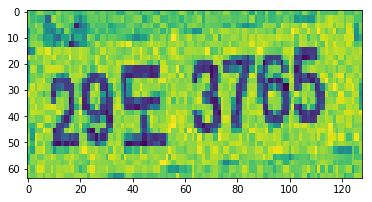

['2', '9', '도', '3', '7', '9', '6']


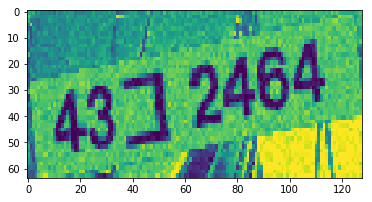

['2', '6', '그', '2', '4', '6', '4']


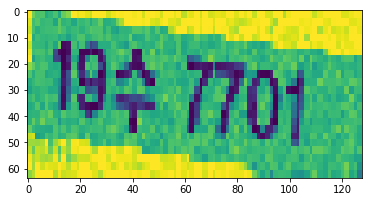

['1', '0', '수', '7', '7', '8', '1']


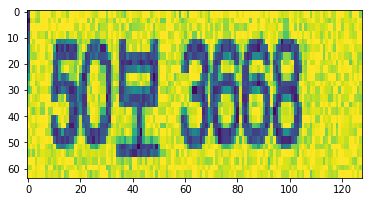

['5', '0', '보', '3', '5', '0', '8']


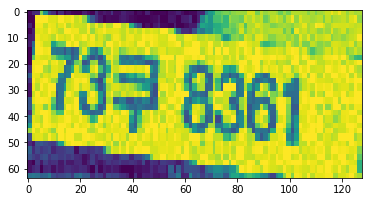

['7', '8', '코', '8', '3', '6', '1']


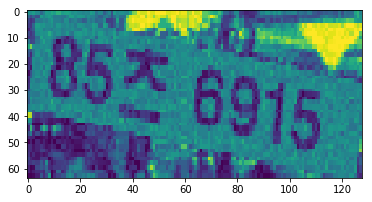

['6', '5', '트', '5', '9', '1', '7']


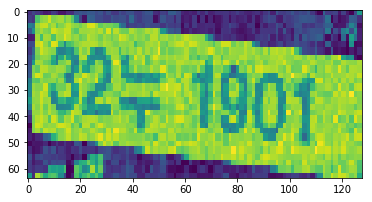

['2', '2', '누', '1', '9', '0', '1']


In [105]:
for i in range(10):
    plt.imshow(v_imgs[i].reshape([64,128]))
    plt.show()
    digits = [JOIN[np.argmax(prediction[0][i])], 
              JOIN[np.argmax(prediction[1][i])], 
              JOIN[np.argmax(prediction[2][i])], 
              JOIN[np.argmax(prediction[3][i])], 
              JOIN[np.argmax(prediction[4][i])], 
              JOIN[np.argmax(prediction[5][i])], 
              JOIN[np.argmax(prediction[6][i])]]
    print(digits)

In [80]:
### START CODE HERE ### (1 line)
preds = model_k.evaluate(v_imgs, [i.reshape([-1,81]) for i in v_annotations], batch_size=32, verbose=1, sample_weight=None)
### END CODE HERE ###
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

32/32 [==============================] - 7s 204ms/step

Loss = 20.388381576538087
Test Accuracy = 2.673846099853516


In [90]:
prediction = model_k.predict(v_imgs[:10])

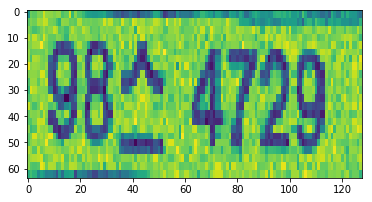

['4', '9', '파', '8', '1', '8', '1']


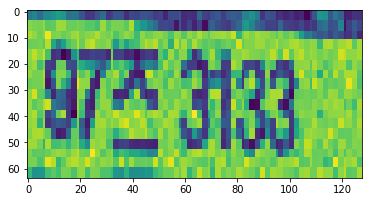

['4', '9', '파', '8', '1', '8', '1']


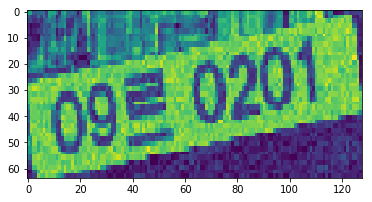

['4', '9', '파', '8', '1', '8', '1']


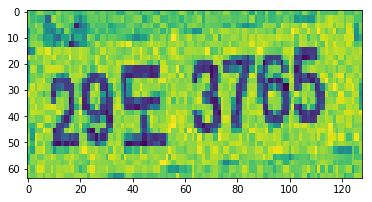

['4', '9', '파', '8', '1', '8', '1']


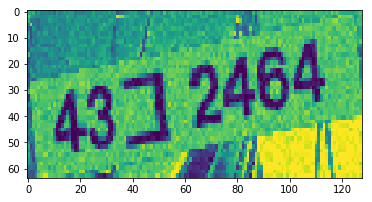

['4', '9', '파', '8', '1', '8', '1']


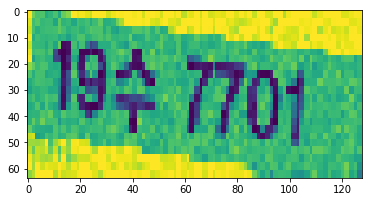

['4', '9', '파', '8', '1', '8', '1']


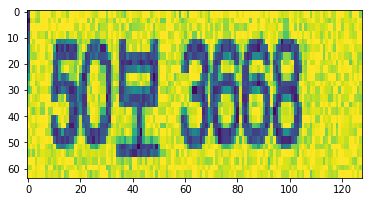

['4', '9', '파', '8', '1', '8', '1']


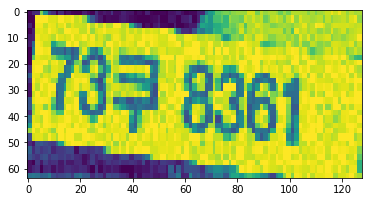

['4', '9', '파', '8', '1', '8', '1']


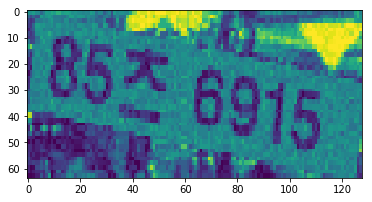

['4', '9', '파', '8', '1', '8', '1']


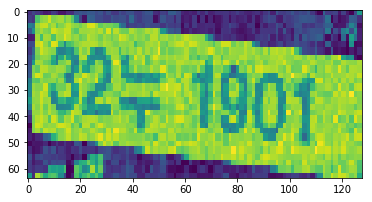

['4', '9', '파', '8', '1', '8', '1']


In [94]:
for i in range(10):
    plt.imshow(v_imgs[i].reshape([64,128]))
    plt.show()
    digits = [JOIN[np.argmax(prediction[0][i])], 
              JOIN[np.argmax(prediction[1][i])], 
              JOIN[np.argmax(prediction[2][i])], 
              JOIN[np.argmax(prediction[3][i])], 
              JOIN[np.argmax(prediction[4][i])], 
              JOIN[np.argmax(prediction[5][i])], 
              JOIN[np.argmax(prediction[6][i])]]
    print(digits)

In [70]:
model_k.fit(t_imgs/255., [i.reshape([-1,81]) for i in t_annotations], epochs=10, batch_size=64, verbose=0)

Epoch 1/10
63/63 [==============================] - 149s 2s/step - loss: 30.0837 - d1_loss: 4.2481 - d2_loss: 4.2463 - d3_loss: 4.3989 - d4_loss: 4.2935 - d5_loss: 4.3326 - d6_loss: 4.3267 - d7_loss: 4.2377 - d1_acc: 0.0885 - d2_acc: 0.0747 - d3_acc: 0.0169 - d4_acc: 0.0811 - d5_acc: 0.0650 - d6_acc: 0.0806 - d7_acc: 0.1042
Epoch 2/10
63/63 [==============================] - 148s 2s/step - loss: 28.7629 - d1_loss: 4.0319 - d2_loss: 4.0202 - d3_loss: 4.3819 - d4_loss: 4.0821 - d5_loss: 4.1222 - d6_loss: 4.1128 - d7_loss: 4.0118 - d1_acc: 0.0980 - d2_acc: 0.1017 - d3_acc: 0.0171 - d4_acc: 0.1037 - d5_acc: 0.0965 - d6_acc: 0.0967 - d7_acc: 0.1029
Epoch 3/10
63/63 [==============================] - 149s 2s/step - loss: 27.5714 - d1_loss: 3.8382 - d2_loss: 3.8273 - d3_loss: 4.3642 - d4_loss: 3.8851 - d5_loss: 3.9232 - d6_loss: 3.9145 - d7_loss: 3.8189 - d1_acc: 0.0980 - d2_acc: 0.1017 - d3_acc: 0.0171 - d4_acc: 0.1037 - d5_acc: 0.0965 - d6_acc: 0.0967 - d7_acc: 0.1029
Epoch 4/10
63/63 [====